# K-means sur données géographiques d'Orange

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  
import math

## PARIS

In [26]:

fichier = open("BS_Locations/Paris_antenna_location.csv",'r')
fichier2 = open("BS_Locations/Paris_antenna_location2.csv",'w')        # On rajoute un tilde à la fin pour éviter d'écraser le fichier source en cas de bug
lignes = fichier.readlines()                # On parcours les lignes du fichier source
for ligne in lignes:
    ligneFinale = ligne.replace(';',', ')            # On remplace tout les espaces par groupe de 4 en tabulation
    fichier2.write(ligneFinale)             # On écrit la nouvelle ligne dans le nouveau fichier
                 
fichier.close()                     # Fermeture du fichier source
fichier2.close()
            
loc_paris=pd.read_csv("BS_Locations/Paris_antenna_location2.csv")
print(loc_paris)

                LocInfo   Coord_X   Coord_y
0      0002f81061005195    593096   2433343
1      0002f81075004a4d    595075   2427749
2      0002f81064009365    595373   2423817
3      0002f810750096cb    595838   2427355
4      0002f81001019edf    595949   2430530
...                 ...       ...       ...
22216  8102f81000016f06    599638   2430478
22217  8102f810000172d3    601638   2431237
22218  8102f81000017555    599045   2429749
22219  8102f81000017bd9    597381   2429565
22220  8102f81000017c5c    600089   2431124

[22221 rows x 3 columns]


### Normalisation 

In [79]:
################# Version pour evaluation 
def normalisation2(df):
    col=df.columns
    result={}
    colonne= df[col[0]] 
    id_per_raw={}
    for j in range(len(colonne)):
        id_per_raw[j]=colonne[j]
    for i in range(1,len(col)):
        colonne= df[col[i]].astype(float)
        result[col[i]]=[]
        max_X=max(colonne)
        min_X=min(colonne)
        for j in range(len(colonne)):
            x=colonne[j]
            if((max_X-min_X)!=0):
                result[col[i]].append(float((x-min_X)/(max_X-min_X)))
    #print(result)
    d=pd.DataFrame (result, columns =[' Coord_X',' Coord_y'])
    return d,id_per_raw

In [80]:
def normalisation(df):
    col=df.columns
    result={}
    colonne= df[col[0]]  ############################
    id_per_raw={}
    for j in range(len(colonne)):
        id_per_raw[j]=colonne[j] ############################
    for i in range(1,len(col)):
        colonne= df[col[i]].astype(float)
        result[col[i]]=[]
        max_X=max(colonne)
        min_X=min(colonne)
        for j in range(len(colonne)):
            x=colonne[j]
            if((max_X-min_X)!=0):
                result[col[i]].append(float((x-min_X)/(max_X-min_X)))
    #print(result)
    d=pd.DataFrame (result, columns =[' Coord_X',' Coord_y'])
    return d

In [6]:
loc_paris_nor=normalisation(loc_paris)
print(loc_paris_nor)

        Coord_X   Coord_y
0      0.136818  0.848465
1      0.243797  0.386761
2      0.259906  0.062232
3      0.285042  0.354242
4      0.291043  0.616293
...         ...       ...
22216  0.490459  0.612001
22217  0.598573  0.674645
22218  0.458403  0.551832
22219  0.368452  0.536646
22220  0.514839  0.665319

[22221 rows x 2 columns]


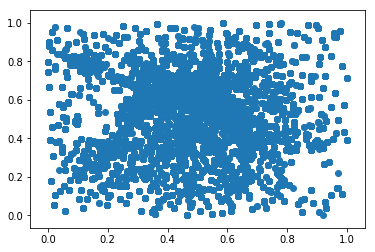

In [7]:
plt.scatter(loc_paris_nor[' Coord_X'],loc_paris_nor[' Coord_y'])

### Distance Euclidienne 

In [38]:
def dist_vect(X,Y):
    return math.sqrt(sum((X-Y)**2))

### Calcul de centroides

In [81]:
def centroide (df):  
    if(isinstance(df.iloc[0],float)):
        return df 
    else:
        return df.mean(axis = 0)

### Inertie d'un cluster

In [82]:
def inertie_cluster(df):
    c=centroide(df)
    som=0
    for i in range(len(df)):
        x=df.iloc[i]
        som+=dist_vect(x,c)**2
    return som

In [11]:
print("inertie :",inertie_cluster(loc_paris_nor))

inertie : 2312.894360519367


### Initialisation des centroides aléatoirement

In [83]:
import random
def initialisation(K,df): 
    m=[]
    l=list(df.index.values)
    while(len(m)<K):
        i=random.choice(l)
        m.append(df.loc[i])
        l.remove(i)
    return pd.DataFrame(m)

In [13]:
Centroides_test = initialisation(10,loc_paris_nor)
Centroides_test

,Coord_X,Coord_y
14964,0.478945,0.800512
11384,0.340397,0.736629
9424,0.000000,0.743067
21576,0.184064,0.768158
13565,0.664631,0.722103
20922,0.441754,0.620419
3347,0.673172,0.443711
11849,0.308287,0.492654
6313,0.281258,0.738280
17050,0.352560,0.574034


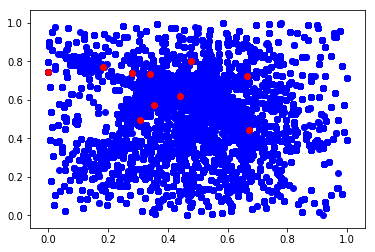

In [14]:
plt.scatter(loc_paris_nor[' Coord_X'],loc_paris_nor[' Coord_y'],color='blue')
plt.scatter(Centroides_test[' Coord_X'],Centroides_test[' Coord_y'],color='red')

Etant donné un exemple et un dataframe contenant un ensemble de centroides, rend l'indice (dans le DataFrame) du centroide dont l'exemple est le plus proche.
En cas d'égalité de distance, le centroide de plus petit indice est choisi.

In [84]:
def plus_proche(x,df_C):
    dis=10000000
    centre=None
    for i in range(len(df_C)):
        c=df_C.iloc[i]
        d=dist_vect(x,c)
        if(dis>d):
            dis=d
            centre=i
    return centre 

Etant donné une base d'apprentissage et un ensemble de centroïdes, rend la matrice d'affectation des exemples de la base aux clusters représentés par chaque centroïde.

In [85]:
def affecte_cluster(df_app, df_C):
    d={}
    l=df_app.index.values
    for i in l:
        x=df_app.loc[i]
        c= plus_proche(x,df_C)
        if(not c in d.keys()):
            d[c]=[]
        d[c].append(i)
    return d

In [17]:
DictAffect = affecte_cluster(loc_paris_nor, Centroides_test)
DictAffect

KeyboardInterrupt: 

### Calcul des nouveaux centroides

In [86]:
def nouveaux_centroides(df_app,d):
    m=[]
    for l in d.values():
        X=[]
        for i in l:
            X.append(df_app.loc[i])
        m.append(centroide(pd.DataFrame(X)))   
    return pd.DataFrame(m)

In [144]:
nouveaux_centroides(loc_paris_nor, DictAffect)

,Coord_X,Coord_y
0,0.126594,0.750257
1,0.259900,0.303513
2,0.406392,0.764026
3,0.363337,0.614236
4,0.625792,0.253698
5,0.517423,0.707121
6,0.736883,0.699430
7,0.079548,0.310811
8,0.491503,0.525347
9,0.293127,0.855861


### L'inertie globale  

In [87]:
def inertie_globale(df_app,d):
    sum=0
    for l in d.values():
        X=[]
        for i in l:
            X.append(df_app.loc[i])
        sum+=inertie_cluster(pd.DataFrame(X))
    return sum  

In [147]:
inertie_globale(loc_paris_nor,DictAffect)

459.39099128328377

### K-means

In [88]:
def kmoyennes(K,df_app,eps,iter_max):
    i=0
    fin=False
    partition=initialisation(K,df_app)
    dic=affecte_cluster(df_app, partition)
    inertie=inertie_globale(df_app,dic)
    
    while(i<iter_max and fin==False):
        partition=nouveaux_centroides(df_app,dic)
        dic=affecte_cluster(df_app, partition)
        inertie_suiv=inertie_globale(df_app,dic)
        if(abs(inertie_suiv-inertie) < eps):
            fin=True
        i+=1
        inertie=inertie_suiv
    return partition,dic

In [21]:
les_centres, l_affectation = kmoyennes(3, loc_paris_nor, 0.05, 100)

In [89]:
def affiche_resultat(DataFnorm,les_centres,l_affectation):
    plt.scatter(les_centres[' Coord_X'],les_centres[' Coord_y'],color='r',marker='x')
    c=[]
    for l in l_affectation.values():
        X=[]
        for i in l:
            X.append(DataFnorm.loc[i])
        plt.scatter(pd.DataFrame(X)[' Coord_X'],pd.DataFrame(X)[' Coord_y'])
    

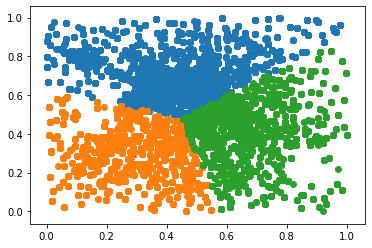

In [159]:
affiche_resultat(loc_paris_nor,les_centres,l_affectation)

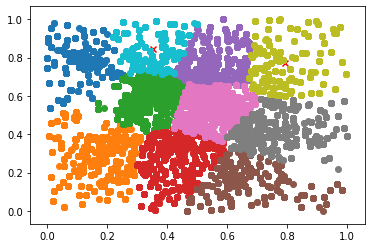

In [160]:
les_centres, l_affectation = kmoyennes(10, loc_paris_nor, 0.05, 100)
affiche_resultat(loc_paris_nor,les_centres,l_affectation)

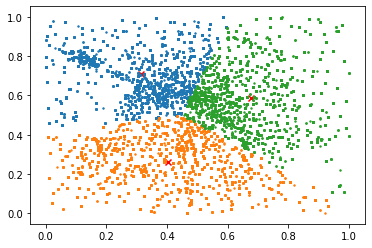

In [165]:
les_centres, l_affectation = kmoyennes(3, loc_paris_nor, 0.05, 100)
affiche_resultat(loc_paris_nor,les_centres,l_affectation)

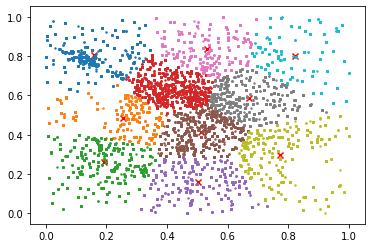

In [166]:
les_centres, l_affectation = kmoyennes(10, loc_paris_nor, 0.05, 100)
affiche_resultat(loc_paris_nor,les_centres,l_affectation)

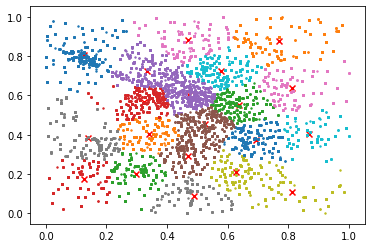

In [167]:
les_centres, l_affectation = kmoyennes(20, loc_paris_nor, 0.05, 100)
affiche_resultat(loc_paris_nor,les_centres,l_affectation)

## LILLE

In [13]:
""" 
fichier = open("BS_Locations/Lille_antenna_location.csv",'r')
fichier2 = open("BS_Locations/Lille_antenna_location2.csv",'w')        # On rajoute un tilde à la fin pour éviter d'écraser le fichier source en cas de bug
lignes = fichier.readlines()                # On parcours les lignes du fichier source
for ligne in lignes:
    ligneFinale = ligne.replace(';',', ')            # On remplace tout les espaces par groupe de 4 en tabulation
    fichier2.write(ligneFinale)             # On écrit la nouvelle ligne dans le nouveau fichier
                 
fichier.close()                     # Fermeture du fichier source
fichier2.close()
"""           
loc_lille=pd.read_csv("BS_Locations/Lille_antenna_location2.csv")
print(loc_lille)

               LocInfo   Coord_X   Coord_y
0     0102f81000655dd0    651625   2626995
1     0102f8100065b98d    652120   2627118
2     0102f81000652901    653420   2625730
3     0102f8100065087d    648111   2624325
4     0102f8100065b721    650285   2625320
...                ...       ...       ...
1389  0002f8101306bfd5    648250   2627725
1390  0002f81013063f09    652584   2626121
1391  0002f8101306579d    653189   2625159
1392  0002f8101307ea7b    651000   2624075
1393  0002f81013064bdc    651280   2627695

[1394 rows x 3 columns]


In [94]:
loc_lille_nor,rrh_id=normalisation2(loc_lille)
print(loc_lille_nor)

       Coord_X   Coord_y
0     0.582534  0.653536
1     0.655554  0.681065
2     0.847323  0.370412
3     0.064169  0.055953
4     0.384865  0.278648
...        ...       ...
1389  0.084673  0.816920
1390  0.724001  0.457923
1391  0.813247  0.242614
1392  0.490338  0.000000
1393  0.531642  0.810206

[1394 rows x 2 columns]


In [230]:
les_centres_lille, l_affectation_lille= kmoyennes(11, loc_lille_nor, 0.05, 100)

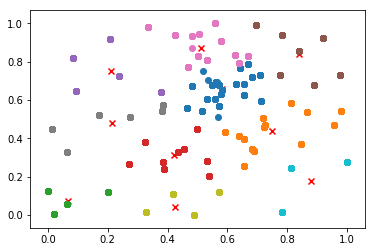

In [96]:
affiche_resultat(loc_lille_nor,les_centres_lille,l_affectation_lille)

## LYON

In [178]:
fichier = open("BS_Locations/Lyon_antenna_location.csv",'r')
fichier2 = open("BS_Locations/Lyon_antenna_location2.csv",'w')        # On rajoute un tilde à la fin pour éviter d'écraser le fichier source en cas de bug
lignes = fichier.readlines()                # On parcours les lignes du fichier source
for ligne in lignes:
    ligneFinale = ligne.replace(';',', ')            # On remplace tout les espaces par groupe de 4 en tabulation
    fichier2.write(ligneFinale)             # On écrit la nouvelle ligne dans le nouveau fichier
                 
fichier.close()                     # Fermeture du fichier source
fichier2.close()
            
loc_lyon=pd.read_csv("BS_Locations/Lyon_antenna_location2.csv")
loc_lyon_nor=normalisation(loc_lyon)

les_centres_lyon, l_affectation_lyon= kmoyennes(10, loc_lyon_nor, 0.05, 100)

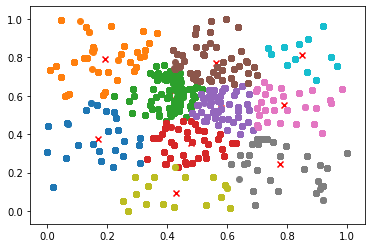

In [179]:
affiche_resultat(loc_lyon_nor,les_centres_lyon,l_affectation_lyon)

## NANTES

In [180]:
fichier = open("BS_Locations/Nantes_antenna_location.csv",'r')
fichier2 = open("BS_Locations/Nantes_antenna_location2.csv",'w')        # On rajoute un tilde à la fin pour éviter d'écraser le fichier source en cas de bug
lignes = fichier.readlines()                # On parcours les lignes du fichier source
for ligne in lignes:
    ligneFinale = ligne.replace(';',', ')            # On remplace tout les espaces par groupe de 4 en tabulation
    fichier2.write(ligneFinale)             # On écrit la nouvelle ligne dans le nouveau fichier
                 
fichier.close()                     # Fermeture du fichier source
fichier2.close()
            
loc_nantes=pd.read_csv("BS_Locations/Nantes_antenna_location2.csv")
loc_nantes_nor=normalisation(loc_nantes)

les_centres_nantes, l_affectation_nantes= kmoyennes(10, loc_nantes_nor, 0.05, 100)

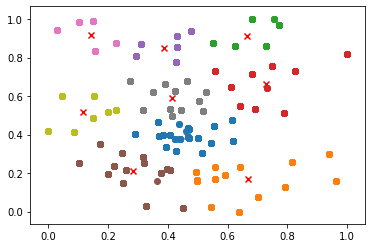

In [181]:
affiche_resultat(loc_nantes_nor,les_centres_nantes,l_affectation_nantes)

# Evaluation des clusters

In [97]:
from scipy.spatial import Voronoi, voronoi_plot_2d,ConvexHull
import numpy as np
import matplotlib.pyplot as plt
import DCCA 
import pandas as pd
from datetime import datetime as dt
import math

In [98]:
df_traffic=pd.read_csv("data/Lille/Lille_traite.csv")
traffic_per_day={}
for t in range(len(df_traffic)):
    day=(df_traffic[' TimeSlot'][t])[1:11]
    if (not day in traffic_per_day.keys()):
        traffic_per_day[day]=df_traffic.loc[df_traffic[' TimeSlot'].str.contains(day)]

In [242]:
dt=1  #DeltaT = 1heure
Nt=int(24/dt)  #nombre de timespan  par jour
NBBU=2
CBBU=5
To=0.5
max_iter=20
iter_converge=6

In [234]:
def generate_day_matrix(day):
    #Nr=df_geo_norm.count()[0]  #nombre des RRHs
    train_traffic=traffic_per_day[day]
    RRH_ID=train_traffic['CellID'].unique()
    Nr=np.size(RRH_ID)  # nbre de RRH dans données trafic < nbre RRHs dans geo données
    r=[]
    F=np.empty([Nr,Nt])
    Fup=np.empty([Nr,Nt])
    for i in range (Nr) :
        id=RRH_ID[i]
        trafic_RRH =train_traffic.loc[train_traffic['CellID']==id,:]
        for h in range(Nt):
            #print(     "H= ",h,"/24")
            if (h <10):
                sh='0'+str(h)
            else:
                sh=str(h)
            tu=0
            td=0
            nbr=0
            j=0
            for ind in (trafic_RRH.index.values):
                slot=trafic_RRH.iloc[j]
                if(slot[' TimeSlot'][12:14] == sh):
                    trafic_RRH=trafic_RRH.drop([ind])
                    nbr+=1
                    td+=slot[' ByteDn']
                    tu+=slot[' ByteUp'] 
                else:
                    j+=1
            if(nbr >0):
                F[i][h]=td/nbr
                Fup[i][h]=tu/nbr 
            else :
                F[i][h]=td
                Fup[i][h]=tu
        r.append(DCCA.RRH(id,i,loc_lille_nor.iloc[i,0],loc_lille_nor.iloc[i,1],F[i]))
    return F,Fup,r

In [109]:
F,Fup,r=generate_day_matrix("2019-05-23")
F_norm=DCCA.normalize_trafic(F)
dict_rrh={}
for i in range(len(r)):
        dict_rrh[r[i].id]=F_norm[i]
        r[i].setTrafic(F_norm[i])

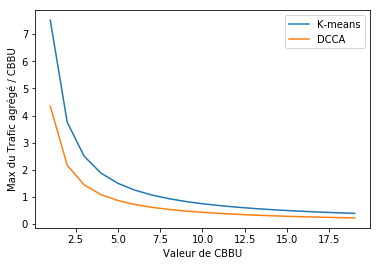

In [247]:
l_BBU=[]
for l in l_affectation_lille.values():
        agg=np.zeros(Nt)
        for i in l:
            id=rrh_id[i]
            if (id in dict_rrh.keys()):
                agg+=dict_rrh[id]
        l_BBU.append(np.max(agg))
val_bbu=np.arange(1,20)
gain=[]
for v in val_bbu:
    gain.append(max(l_BBU)/v)
plt.plot(val_bbu,gain,label="K-means")
plt.plot(val_bbu,gainDCCA,label="DCCA")
plt.ylabel("Max du Trafic agrégé / CBBU")
plt.xlabel("Valeur de CBBU")
plt.legend()
plt.show()

In [243]:
T=DCCA.peak_tracking(CBBU,F_norm,r) 
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)

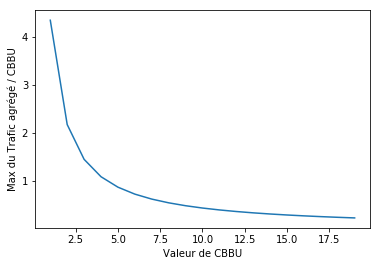

In [244]:
l_BBU2=[]
k=0
for c in P:
    if(c!= []):
        agg=DCCA.aggregationTrafic(c)
        l_BBU2.append(np.max(agg))
        k+=1
val_bbu=np.arange(1,20)
gainDCCA=[]
for v in val_bbu:
    gainDCCA.append(max(l_BBU2)/v)
plt.plot(val_bbu,gainDCCA)
plt.ylabel("Max du Trafic agrégé / CBBU")
plt.xlabel("Valeur de CBBU")
plt.show()

In [246]:
c_tot=sum(np.max(F_norm,axis=1))
k_means_MSG=c_tot/sum(l_BBU)
DCCA_MSG=c_tot/sum(l_BBU2)
print("k_means_MSG = ",k_means_MSG)
print("DCCA_MSG = ",DCCA_MSG)
print(k)

k_means_MSG =  1.256269571106413
DCCA_MSG =  1.2574256782923283
[7.511687459267765, 1.0248889126302207, 1.2675554997101899, 2.143307149575378, 3.4544895960397777, 2.2323110798973773, 1.4236314619378838, 1.7376125794328032, 1.3947855460257201, 0.798159599973548, 1.2225393071465414] [0.00947636035045595, 0.3255547481158989, 2.270512473764218, 0.008302141705521656, 1.4251755961607566, 2.8055677937023695, 1.8892547622148883, 1.8405078566285649, 1.5098148756191054, 0.01937482407822788, 0.40145955053930865, 0.4260410485131404, 0.4539232794016158, 4.3429661653756755, 3.5014985230851794, 2.95927805026212] 16


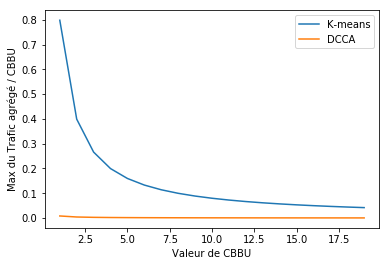

[0.00947636035045595, 0.3255547481158989, 2.270512473764218, 0.008302141705521656, 1.4251755961607566, 2.8055677937023695, 1.8892547622148883, 1.8405078566285649, 1.5098148756191054, 0.01937482407822788, 0.40145955053930865, 0.4260410485131404, 0.4539232794016158, 4.3429661653756755, 3.5014985230851794, 2.95927805026212] [7.511687459267765, 1.0248889126302207, 1.2675554997101899, 2.143307149575378, 3.4544895960397777, 2.2323110798973773, 1.4236314619378838, 1.7376125794328032, 1.3947855460257201, 0.798159599973548, 1.2225393071465414]


In [253]:
l_BBU_min=[]
for l in l_affectation_lille.values():
        agg=np.zeros(Nt)
        for i in l:
            id=rrh_id[i]
            if (id in dict_rrh.keys()):
                agg+=dict_rrh[id]
        l_BBU_min.append(np.max(agg))
val_bbu=np.arange(1,20)
gain_min=[]
for v in val_bbu:
    gain_min.append(min(l_BBU_min)/v)
l_BBU2_min=[]
k=0
for c in P:
    if(c!= []):
        agg=DCCA.aggregationTrafic(c)
        l_BBU2_min.append(np.max(agg))
        k+=1
gainDCCA_min=[]
for v in val_bbu:
    gainDCCA_min.append(min(l_BBU2_min)/v)
plt.plot(val_bbu,gain_min,label="K-means")
plt.plot(val_bbu,gainDCCA_min,label="DCCA")
plt.ylabel("Max du Trafic agrégé / CBBU")
plt.xlabel("Valeur de CBBU")
plt.legend()
plt.show()
print(l_BBU2_min,l_BBU_min)